# Interpretability Analysis of CEED

## Imports and set up

In [4]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
#for some strange reason, this needs to be run twice. spikeinterface will not load on first run...
from pathlib import Path
import numpy as np
import h5py
from tqdm.auto import tqdm, trange
import scipy.io
import time
import torch
import random
import math
import shutil
from sklearn.decomposition import PCA
from tslearn.preprocessing import TimeSeriesResampler
import scipy as sp
import scipy.signal
import os
import pandas as pd
from torch import nn
from scipy.spatial.distance import cdist
# import spikeinterface.core as sc
# import spikeinterface.full as si

from analysis.proj import learn_manifold_umap, pca_train, pca
from analysis.plotting import plot_gmm, plot_closest_spikes
from analysis.encoder_utils import load_GPT_backbone, get_fcenc_backbone
from analysis.cluster import GMM, HDBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import adjusted_rand_score
from analysis.cluster import MeanShift
from analysis.benchmarking import class_scores, avg_score, per_class_accs, avg_class_accs
import matplotlib.patheffects as pe
import matplotlib.pyplot as plt

from load_models import load_ckpt

# from spike_psvae.denoise import SingleChanDenoiser

import colorcet as cc
def get_ccolor(k):
    if k == -1:
        return "#808080"
    else:
        return ccolors[k % len(ccolors)]
ccolors = cc.glasbey[:31]

In [6]:
import matplotlib.pyplot as plt
# %matplotlib inline
plt.rc("figure", dpi=100)
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12
plt.rc('font', size=SMALL_SIZE)
plt.rc('axes', titlesize=MEDIUM_SIZE)
plt.rc('axes', labelsize=SMALL_SIZE)
plt.rc('xtick', labelsize=SMALL_SIZE)
plt.rc('ytick', labelsize=SMALL_SIZE)
plt.rc('legend', fontsize=SMALL_SIZE)
plt.rc('figure', titlesize=BIGGER_SIZE)

## Load Data and Model

In [7]:
# data_path = ('/Users/noah/Downloads/400neuron_200spike_celltype_singlechan_dataset/spikes_val.npy')
data_path = ('/home/noah/code/400neuron_200spike_celltype_singlechan_dataset/spikes_train.npy')

In [8]:
spikes = np.load(data_path) #ibl data so probably arranged as (neuron, channels, time)
print(spikes.shape)
spike_data = np.array([neuron[0, :] for neuron in spikes])
print(spike_data.shape)

(80000, 1, 121)
(80000, 121)


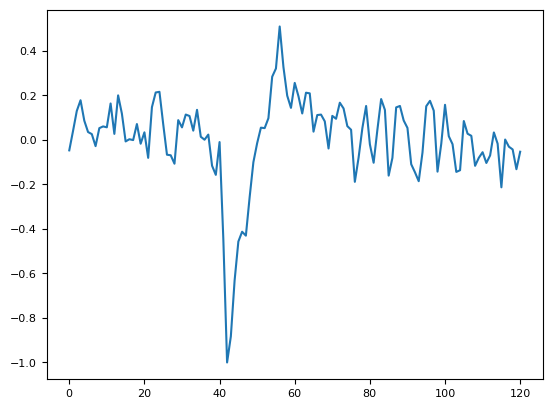

In [9]:
plt.plot(spike_data[3])
plt.show()

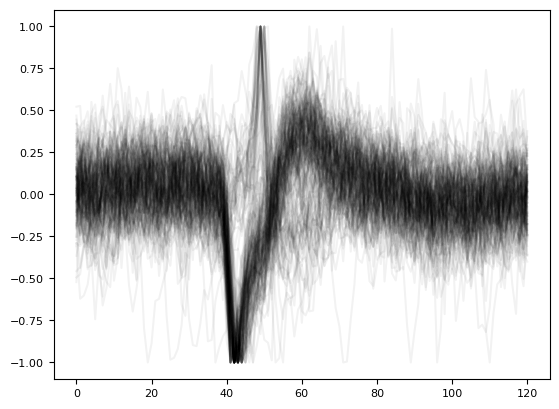

In [10]:
for spike in spike_data[0:200]:
    plt.plot(spike, alpha=.05, color='k')
plt.show()

In [11]:
labels_path = ('/home/noah/code/400neuron_200spike_celltype_singlechan_dataset/labels_train.npy')

In [12]:
labels = np.load(labels_path)

In [13]:
labels.shape

(80000,)

In [14]:
label_values = np.unique(labels) #399 distinct cells???
labels

array([  0,   0,   0, ..., 399, 399, 399])

In [15]:
#labelled spikes
spikes_labelled = list(zip(labels, spike_data))

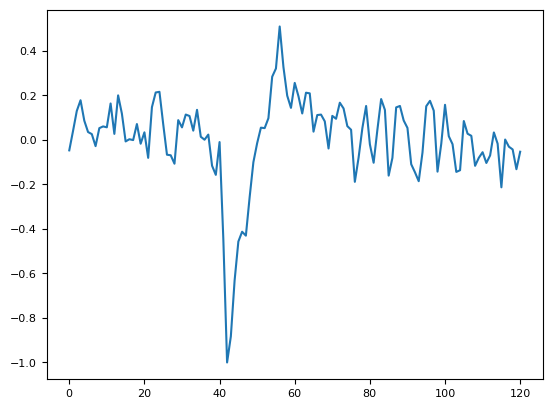

In [16]:
plt.plot(spikes_labelled[3][1])
plt.show()

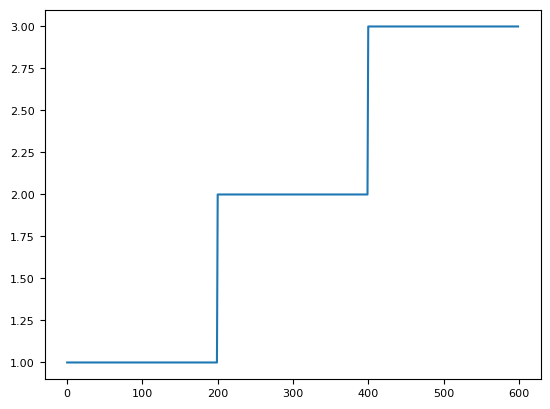

In [17]:
plt.plot(labels[200:800])#200 spikes per label

In [18]:
# [labelled_spike[0] for labelled_spike in spikes_labelled[-200:-1]]

In [19]:
#group spikes by label - labells seem completely wrong...
#likely due to really bad spike sorting

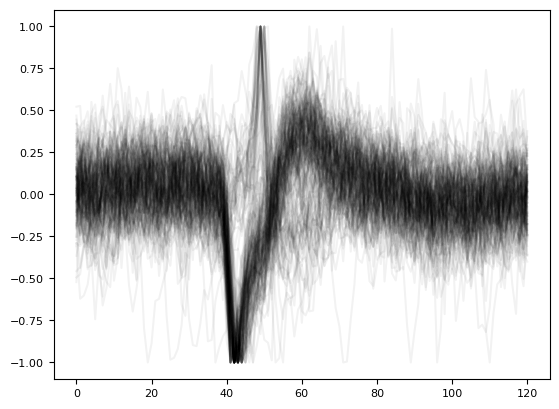

In [20]:
for spike in spike_data[0:200]:
    plt.plot(spike, alpha=.05, color='k')
plt.show()

## Load model and test some data

In [21]:
#loading CEED model and doing some inference
checkpoint_path = Path('/home/noah/code/checkpoint_epoch600_1.pth') #this is for transformer model!

In [22]:
print(torch.cuda.is_available(), torch.cuda.current_device(), torch.cuda.get_device_name(0))

True 0 NVIDIA GeForce GTX TITAN X


In [23]:
map_location=torch.device(0)
model_dict = torch.load(checkpoint_path, map_location)
model_dict.keys()

dict_keys(['epoch', 'arch', 'optimizer', 'state_dict'])

In [24]:
is_multi_chan = False
model = load_ckpt(checkpoint_path, multi_chan=False, rep_dim=128, pos_enc='conseq', 
                  rep_after_proj=True,num_classes=400).to('cuda')


Using projector; batchnorm False with depth 3; hidden_dim=512
number of parameters: 0.63M
Using projector; batchnorm False with depth 3; hidden_dim=512
missing keys []
unexpected keys []


In [25]:
model

Encoder(
  (backbone): Single_GPT(
    (transformer): ModuleDict(
      (wte): Linear(in_features=1, out_features=32, bias=True)
      (wpe): Embedding(121, 32)
      (drop): Dropout(p=0.0, inplace=False)
      (h): ModuleList(
        (0-19): 20 x Block(
          (ln_1): LayerNorm()
          (attn): CausalSelfAttention(
            (c_attn): Linear(in_features=32, out_features=96, bias=False)
            (c_proj): Linear(in_features=32, out_features=32, bias=False)
            (attn_dropout): Dropout(p=0.0, inplace=False)
            (resid_dropout): Dropout(p=0.0, inplace=False)
          )
          (ln_2): LayerNorm()
          (mlp): MLP(
            (c_fc): Linear(in_features=32, out_features=128, bias=False)
            (c_proj): Linear(in_features=128, out_features=32, bias=False)
            (dropout): Dropout(p=0.0, inplace=False)
          )
        )
      )
      (ln_f): LayerNorm()
    )
    (lm_head): Linear(in_features=32, out_features=128, bias=False)
    (projector)

## Inference

In [26]:
spike = torch.from_numpy(spikes[0].astype('float32')).to('cuda')
data = torch.unsqueeze(spike, dim=-1)
feature = model(data)

In [27]:
data.shape

torch.Size([1, 121, 1])

In [28]:
print(spike_data[0].shape)
test = spike_data[0].reshape(1,121,1)
test.shape
#reshaped to be dimention 3 (makes sense: neuron, channel, time) but this isnt the order for some reason...
#must be reshaped as (1,121,1) 121 repesents time points, unsure about other two
#first one is batch! ie number of samples per batch to be infered at once

(121,)


(1, 121, 1)

In [29]:
feature = model(torch.from_numpy(test.astype('float32')).to('cuda'))
#note: must be float32 before use with this model - unsure why?


In [30]:
feature = feature.detach().to('cpu') #this is my 5 dimentional embedding of the spike
#detach removes something - look this up 

In [31]:
feature

tensor([[ 7.6597,  8.0259, -2.4978,  4.3177, -7.4989]])

## Do inference on 10 neurons from each cluster

In [32]:
clusters = [spike_data[x:x+10] for x in range(0, len(spike_data),200)]
# https://stackoverflow.com/questions/15890743/how-can-you-split-a-list-every-x-elements-and-add-those-x-amount-of-elements-to

np.shape(clusters)
#400 clusters, 10 spikes in each cluster, 121 timepoints


(400, 10, 121)

In [33]:
#mix clusters
sample_data = np.array(clusters).reshape(4000,121)
sample_data.shape

(4000, 121)

In [34]:
# #all cells
# print(spike_data.shape)
# sample_data = spike_data

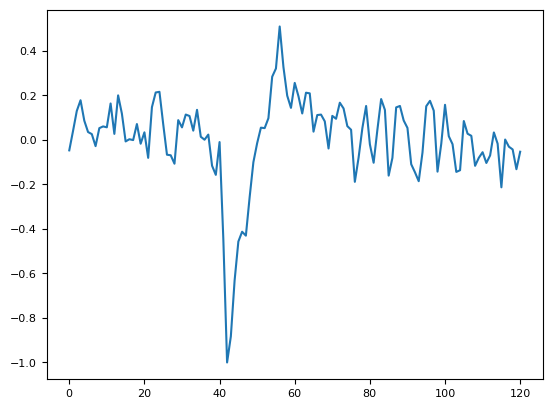

In [35]:
#inspect this to make sure transform worked
plt.plot(sample_data[3])
plt.show()

In [36]:
# calculate max batch size for gpu
#install einops for this

batch = 50
cells = sample_data.shape[0]
timepoints = sample_data.shape[1]

In [37]:
#convert to tensor, batch data for gpu, and send to gpu
sample_data_tensor = torch.from_numpy(sample_data.astype('float32')) #must be float32?
sample_data_tensor = sample_data_tensor.reshape(batch, int(cells/batch), timepoints)
sample_data_tensor = sample_data_tensor.to('cuda')
print(sample_data_tensor.shape, sample_data_tensor.device)

torch.Size([50, 80, 121]) cuda:0


In [38]:
#batch inference on these clusters
from tqdm import tqdm

#put this all on the gpu - it will be much faster
# embeddings = []
# with torch.no_grad():
#     for spike in tqdm(sample_data):
#         spike = torch.from_numpy(spike[None,:].astype('float32'))
#         data = torch.unsqueeze(spike, dim=-1)
#         feature = model(data)
#         embeddings.append(feature)
# embeddings = torch.concatenate(embeddings).detach().squeeze().numpy()

#batched on gpu is fast!
embeddings = []
with torch.no_grad():
    for spike in tqdm(sample_data_tensor):
        data = torch.unsqueeze(spike, dim=-1)
        feature = model(data)
        embeddings.append(feature)
embeddings = torch.concatenate(embeddings).to('cpu').detach().squeeze().numpy()

100%|███████████████████████████████████████████| 50/50 [00:01<00:00, 25.19it/s]


In [39]:
embeddings.shape

(4000, 5)

In [40]:
embeddings[1]

array([ 6.3049474, 11.139812 , -6.123519 ,  2.582499 , -4.0164294],
      dtype=float32)

In [41]:
embeddings[0:10]

array([[ 7.659664  ,  8.025943  , -2.4978054 ,  4.317729  , -7.49888   ],
       [ 6.3049474 , 11.139812  , -6.123519  ,  2.582499  , -4.0164294 ],
       [10.599628  ,  9.848971  , -4.751801  ,  1.8047538 , -0.62322545],
       [ 7.7191505 , 10.725369  , -3.6351464 ,  4.1765585 ,  0.3709853 ],
       [ 5.538286  , -1.5821235 ,  4.7974305 ,  9.583702  ,  0.80064577],
       [ 4.2042446 ,  0.9567585 , -0.21094032,  9.349407  ,  2.1884408 ],
       [ 5.622854  , 10.325411  , -5.962663  , -0.48255193, -4.3902802 ],
       [ 7.7639513 , 10.791391  , -3.9679835 ,  2.866638  , -4.4320197 ],
       [ 5.5775604 , 11.661614  , -4.8199415 , -2.6868794 ,  0.04731659],
       [ 5.940217  , -0.37985778,  4.1088014 ,  8.324646  ,  2.4412868 ]],
      dtype=float32)

## Inference on all neurons, gpu and batched

In [42]:
print(spike_data.shape)
batch = 100
cells = spike_data.shape[0]
timepoints = spike_data.shape[1]

(80000, 121)


In [43]:
#convert to tensor, batch data for gpu, and send to gpi
sample_data_tensor = torch.from_numpy(spike_data.astype('float32')) #must be float32?
sample_data_tensor = sample_data_tensor.reshape(batch, int(cells/batch), timepoints)
sample_data_tensor = sample_data_tensor.to('cuda')
print(sample_data_tensor.shape, sample_data_tensor.device)

torch.Size([100, 800, 121]) cuda:0


In [44]:
embeddings_all = []
with torch.no_grad():
    for spike in tqdm(sample_data_tensor):
        data = torch.unsqueeze(spike, dim=-1)
        feature = model(data)
        embeddings_all.append(feature)
embeddings_all = torch.concatenate(embeddings_all).to('cpu').detach().squeeze().numpy()

100%|█████████████████████████████████████████| 100/100 [00:36<00:00,  2.72it/s]


In [45]:
embeddings_all.shape

(80000, 5)

In [46]:
embeddings = embeddings_all

## visualisation and clustering stuff

In [47]:
#pca to 2d
_pca = PCA(n_components=3)
_pca.fit(embeddings)

PCA(n_components=3)

In [48]:
print(_pca.explained_variance_ratio_)
print(_pca.singular_values_)

[0.3132892  0.23806138 0.20764804]
[1365.4012 1190.2332 1111.6075]


In [49]:
reduced_data = _pca.transform(embeddings)

In [50]:
# !pip install ipympl
#this didnt work 

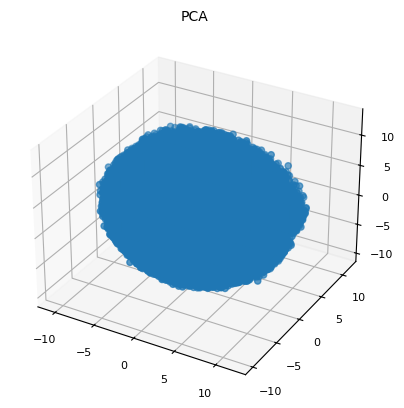

In [51]:
# plt.scatter(reduced_data[:,0], reduced_data[:,1])
# https://stackoverflow.com/questions/47311632/jupyter-how-to-rotate-3d-graph

# %matplotlib notebook
# %matplotlib widget
# %matplotlib ipympl
from mpl_toolkits.mplot3d import axes3d    

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(reduced_data[:,0], reduced_data[:,1], reduced_data[:,2])
#nothing obvious in 3d scatter of PCA
plt.title('PCA')
plt.show()

In [52]:
#maybe try with Umap clustering now :)
#then k means to cluster - dwt k means? works on time serie directly. otherwise pca needed


In [53]:
import umap

In [54]:
manifold = umap.UMAP(random_state=42, n_components=2).fit(embeddings)
X_reduced = manifold.transform(embeddings)

In [55]:
X_reduced.shape

(80000, 2)

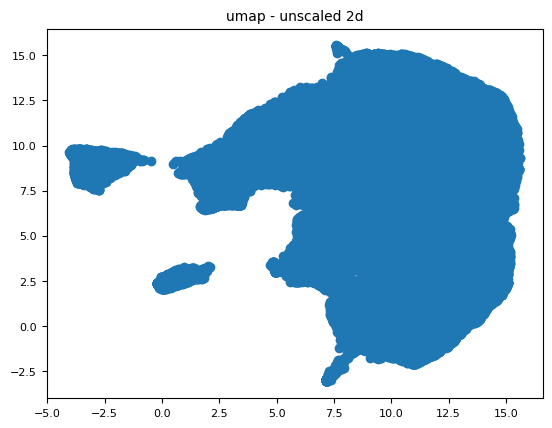

In [56]:
plt.scatter(X_reduced[:, 0], X_reduced[:, 1])
# fig = plt.figure()
# ax = fig.add_subplot(projection='3d')

# ax.scatter(X_reduced[:,0], X_reduced[:,1], X_reduced[:,2])
# #nothing obvious in 3d scatter of PCA
plt.title('umap - unscaled 2d')
plt.show()

In [57]:
#appropriate scaling 
from sklearn.preprocessing import QuantileTransformer
from sklearn.impute import SimpleImputer

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler


In [58]:
scaled_data = StandardScaler().fit_transform(embeddings)
manifold_scaled = umap.UMAP(random_state=42, n_components=2).fit(scaled_data)
X_reduced_scaled = manifold_scaled.transform(scaled_data)

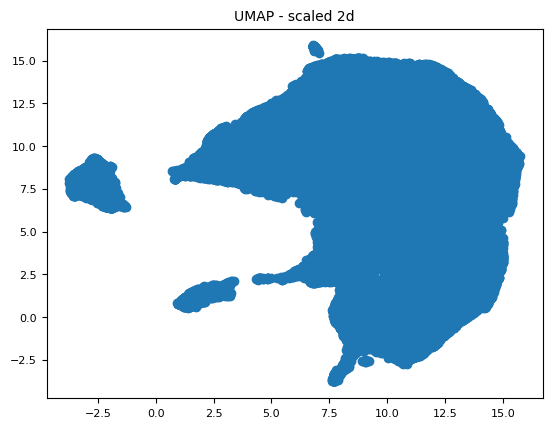

In [59]:
plt.scatter(X_reduced_scaled[:, 0], X_reduced_scaled[:, 1])
plt.title('UMAP - scaled 2d')
plt.show()


In [60]:
scaled_data = StandardScaler().fit_transform(embeddings)
manifold_scaled = umap.UMAP(random_state=42, n_components=3).fit(scaled_data)
X_reduced_scaled = manifold_scaled.transform(scaled_data)

In [61]:
X_reduced_scaled.shape

(80000, 3)

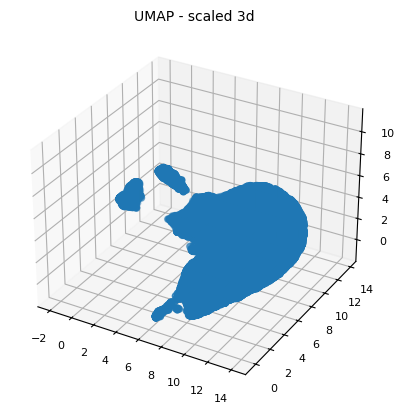

In [62]:
# plt.scatter(X_reduced_scaled[:, 0], X_reduced_scaled[:, 1])
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(X_reduced_scaled[:,0], X_reduced_scaled[:,1], X_reduced_scaled[:,2])
#nothing obvious in 3d scatter of PCA
plt.title('UMAP - scaled 3d')
plt.show()

In [63]:
# comparison with different scalers
qscaled_data = QuantileTransformer(n_quantiles=50).fit_transform(embeddings)
manifold_q = umap.UMAP(random_state=42, n_components=3).fit(qscaled_data)
X_reduced_scaled_q = manifold_q.transform(qscaled_data)


In [64]:
X_reduced_scaled_q.shape

(80000, 3)

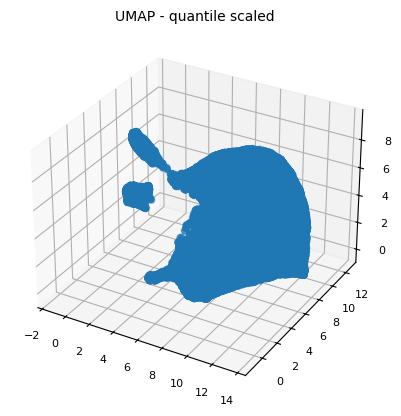

In [65]:
# plt.scatter(X_reduced_scaled[:, 0], X_reduced_scaled[:, 1])
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(X_reduced_scaled_q[:,0], X_reduced_scaled_q[:,1], X_reduced_scaled_q[:,2])
#nothing obvious in 3d scatter of PCA
plt.title('UMAP - quantile scaled')
plt.show()

In [66]:
manifold_q_2d = umap.UMAP(random_state=42, n_components=2).fit(qscaled_data)
X_reduced_scaled_q_2d = manifold_q_2d.transform(qscaled_data)

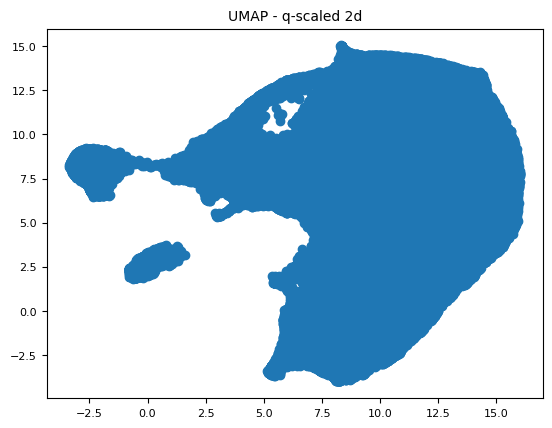

In [67]:
plt.scatter(X_reduced_scaled_q_2d[:, 0], X_reduced_scaled_q_2d[:, 1])
plt.title('UMAP - q-scaled 2d')
plt.show()

In [68]:
# 3 clusters says umap - will check with kmeans as well :)

## Clustering
NOTE: load wavemap data so I can have some labels at some point

In [69]:
import sys; sys.executable

'/home/noah/mambaforge/envs/ceed/bin/python'

In [1]:
# kmeans test

from sklearn.cluster import KMeans
import numpy as np
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt


X,y = make_blobs(n_samples = 10,n_features = 2,centers = 3,random_state = 23)
print(X[:,0])
plt.scatter(X[:,0], X[:,1])
plt.show()
kmeans = KMeans(3)
kmeans.fit(X)
# data = np.ones((20,5))
# data.shape

ModuleNotFoundError: No module named 'sklearn'

In [71]:
print(embeddings[0:5])
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans

kmeans=KMeans(n_clusters=2,init='k-means++',n_init=10, max_iter=100)
kmeans.fit(embeddings[0:5])
# gmm = GaussianMixture(1, random_state=42, max_iter=1).fit(embeddings[0:5])


[[ 7.659663    8.025941   -2.4978063   4.317729   -7.4988794 ]
 [ 6.304947   11.1398115  -6.1235185   2.5824986  -4.016429  ]
 [10.5996275   9.84897    -4.751801    1.8047535  -0.62322456]
 [ 7.7191515  10.725367   -3.6351457   4.176558    0.37098518]
 [ 5.538286   -1.5821236   4.797431    9.583703    0.8006465 ]]


KMeans(max_iter=100, n_clusters=2, n_init=10)

In [85]:
from sklearn.mixture import GaussianMixture
import numpy as np


labels = []
aic_scores = []
bic_scores = []
for num_clust in np.arange(10)+1:
    gmm = GaussianMixture(num_clust, random_state=0).fit(X_reduced_scaled_q)
    gmm_labels = gmm.predict(X_reduced_scaled_q)
    bic_score = gmm.bic(X_reduced_scaled_q)
    aic_score = gmm.aic(X_reduced_scaled_q)
    labels.append(gmm_labels)
    bic_scores.append(bic_score)
    aic_scores.append(aic_score)

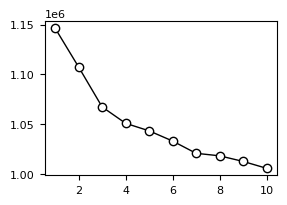

In [86]:
f, arr = plt.subplots()
f.set_size_inches(3., 2.)
arr.plot(np.arange(10) + 1, bic_scores,c='k', marker='o',fillstyle='full',markerfacecolor='w',linewidth=1,markeredgewidth=1)
